# Amazon Reviews Text Classification Notebook
---

In [1]:
# import relevant Python libraries
import numpy as np
import pandas as pd
from scipy import stats as sps
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Latex
from sklearn import preprocessing
import json
import random
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score


# **Objectives**

**Task for this Dataset:**

The task for this dataset will be a classification task. With this dataset we are attempting to create a machine learning model to accurately classify the language of texts from Amazon product reviews: English, German, French, and Spanish.

**Type of Machine Learning Problem:**

This problem is a supervised machine learning problem because the labels are provided in the dataset (language of data samples: 4 total). The labels are provided in the respective json file name (i.e. English reviews are provided in the json file with “en” in file name).

**Motivation:**

Increasingly, people are transitioning to online markets, like Amazon, as it becomes easier to place orders and purchase items over the internet. Amazon has been around since 1994 and has since then grown to millions of users around the world and has become a prominent global business. Amazon extended their marketplace to many regions where customers speak different languages. The language of a marketplace does not necessarily always match the language of a review placed by customers. In this project, we are going to try and create a machine learning model to classify the language of each text review: English, Japanese, German, French, Chinese, and Spanish. In essence, we are trying to create a model that can detect the language of texts. Such machine learning model can help break the language barrier between buyers and sellers. I find the concept of Languages and linguistics interesting because they are an integral part of humanity. Languages enable us to share ideas, thoughts and feelings. Every language has its unique rules and syntax, but they allow humans to communicate and express themselves in different ways. Understanding different languages is important for businesses to build connections and grow a network. This project gives us an opportunity to create a machine learning system by using methods learned in class to classify language of texts. 


# **Setup**

#### **Folder Structure:**
```
📂AmazonReviews
 ┃
 ┣ 📙text-langauge-classification.ipynb
 ┃
 ┣ 📝 dataset_de_test.json
 ┣ 📝 dataset_en_test.json
 ┣ 📝 dataset_es_test.json
 ┣ 📝 dataset_fr_test.json
 ┃
 ┣ 📝 dataset_de_train.json
 ┣ 📝 dataset_en_train.json
 ┣ 📝 dataset_es_train.json
 ┗ 📝 dataset_fr_train.json
 ```
 #### **Dataset link:**
 https://s3.console.aws.amazon.com/s3/buckets/amazon-reviews-ml/?region=us-west-2&tab=objects
 #### **Kernel:**
 base Python 3.9.12 Conda env

# **1. Brief Exploration of Dataset**

In this section, we will be carry out a brief exploration of our dataset. We must first note that the training data is given in 4 .json file (see folder structure) for each respective langauges: German (de), English (en), Spanish (es), French (fr), Japanese (ja), and Chinese (zh). In order to start any exploration, we must first parse the json data into our python environment.

<AxesSubplot:ylabel='stars'>

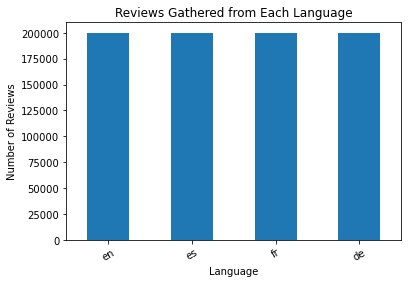

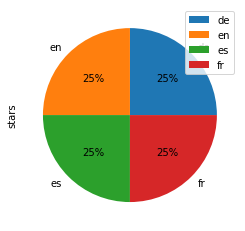

In [2]:
en_df = pd.read_json('dataset_en_train.json', lines=True, orient='columns')
es_df = pd.read_json('dataset_es_train.json', lines=True, orient='columns')
fr_df = pd.read_json('dataset_fr_train.json', lines=True, orient='columns')
de_df = pd.read_json('dataset_de_train.json', lines=True, orient='columns')
lang_frames = [en_df, es_df, fr_df, de_df]
all_reviews_df = pd.concat(lang_frames)
all_reviews_df['language'].value_counts().plot(kind="bar", title="Reviews Gathered from Each Language")
# Rotate the x-labels by 30 degrees, and keep the text aligned horizontally
plt.xticks(rotation=30, horizontalalignment="center")
plt.title("Reviews Gathered from Each Language")
plt.xlabel("Language")
plt.ylabel("Number of Reviews")
all_reviews_df.groupby(['language']).sum().plot(kind='pie', y='stars', autopct='%1.0f%%')

Note that there are a total of 800,000 reivews with 200,000 reviews from each lanaguage .json file. Based on the dataset, we see that the data is pretty much uniform across all langauges. The pie chart also shows that the dataset is balanced among all six language. Each reviews from each language comprise of approximately 25% of the total reviews. 

We will also check for null values in the dataset / pandas dataframe.

In [3]:
all_reviews_df.isnull().sum()

review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
dtype: int64

We see that there are no null values present in this dataset.

# **2. Pre-processing**

On top of parsing the json data into pandas dataframe, we will be employing sampling method to the large dataset. The reason for sampling is because we do not have enough computing or processing power to analyze all of the 800,000 samples in the dataset. We will be randomly sampling 500 reviews from each language json data. It was found that 500 reviews is the threshold before our computing resources and kernel crashes.

In [4]:
en_df = pd.read_json('dataset_en_train.json', lines=True, orient='columns').sample(500)
es_df = pd.read_json('dataset_es_train.json', lines=True, orient='columns').sample(500)
fr_df = pd.read_json('dataset_fr_train.json', lines=True, orient='columns').sample(500)
de_df = pd.read_json('dataset_de_train.json', lines=True, orient='columns').sample(500)
lang_frames = [en_df, es_df, fr_df, de_df]
all_reviews_df = pd.concat(lang_frames)
print('English Reviews: ', len(en_df))
print('Spanish Reviews: ', len(es_df))
print('French Reviews: ', len(fr_df))
print('German Reviews:  ', len(de_df))
print('Total Reviews: ',len(all_reviews_df))

English Reviews:  500
Spanish Reviews:  500
French Reviews:  500
German Reviews:   500
Total Reviews:  2000


We need to do some preprocessing for the data. The text data must meet the following preprocessing conditions:

1. All words in texts are converted to lower case.
2. All digits and numbers are removed from the text sentences.
3. Punctuation marks and special characters are removed.
4. All sentences are concatenated with space in between.
5. Series of contiguous white spaces (e.g double spaces) and trailing spaces are replaced with a single space.

By cleaning our raw text data this way, we will be able to use sklearn's CountVectorizer() to create our bags of words model (see section 3 Feature Extraction / Engineering and Feature learning).

In [5]:
#remove special characters from text column
all_reviews_df['review_title'] = all_reviews_df['review_title'].str.replace('\W', ' ', regex=True)
# remove numbers and digits form text
all_reviews_df['review_title'] = all_reviews_df['review_title'].str.replace('\d', ' ', regex=True)
# convert text to lower case
all_reviews_df['review_title'] = all_reviews_df['review_title'].str.lower()
# remove n spaces and convert to a single space
all_reviews_df['review_title'] = all_reviews_df['review_title'].str.replace('\s{2,}', ' ', regex=True)
# remove leading and trailing spaces
all_reviews_df['review_title'].str.strip()
all_reviews_df.head(10)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
82839,en_0830189,product_en_0217185,reviewer_en_0640157,3,"Received this item as promised, was disappoint...",not very thick rather thin material,en,sports
55327,en_0390897,product_en_0419361,reviewer_en_0088613,2,The size is not accurate,don t choose size according to age,en,apparel
168747,en_0771293,product_en_0601512,reviewer_en_0600673,5,First book I read beginning to end in ages. Wo...,great book,en,digital_ebook_purchase
43056,en_0268049,product_en_0972973,reviewer_en_0182857,2,Not real happy with it. It's to tight on the g...,to tight,en,sports
145893,en_0583780,product_en_0968769,reviewer_en_0127544,4,Great for dissolving protein powder into morni...,great for dissolving protein powder into morni...,en,kitchen
16679,en_0256457,product_en_0519112,reviewer_en_0658287,1,"Very first time I used this, I accidentally kn...",disappointed,en,kitchen
38863,en_0172955,product_en_0111840,reviewer_en_0510887,1,This was not a good map. Nobody had a good map...,i really needed a good map in budapest,en,book
78580,en_0517203,product_en_0771133,reviewer_en_0240534,2,Each one worked only a couple on/offs..just ta...,waste of money,en,sports
6854,en_0052260,product_en_0878400,reviewer_en_0005586,1,"Not blended, sprayed on like water--nearly cle...",not blended got a sunburn,en,beauty
157170,en_0942956,product_en_0358498,reviewer_en_0787527,4,Beautiful colors however they did not have the...,misrepresentation,en,home


We will be removing all the columns that we will not be needing for our analysis. We will be keeping our raw text data: review_title, and label: language.

In [6]:
all_reviews_df = all_reviews_df[["review_title", "language"]]
print(all_reviews_df.head(2))
print(all_reviews_df.shape)

                              review_title language
82839  not very thick rather thin material       en
55327   don t choose size according to age       en
(2000, 2)


# **3. Feature Extraction / Feature Learning**

In our next step, we will be label encoding our output feature. Based on the way the dataframe is loaded. The labelencoder will encode language as: 

0: en, 
1: es,
2: fr,
3: de,

By encoding our label, we will be able to perform Multinomial Naivve Bayes and K-Nearest Neighbors using sklearn library

In [7]:
le = preprocessing.LabelEncoder();
all_reviews_df['language'] = le.fit_transform(all_reviews_df['language'])
all_reviews_df.head()

,review_title,language
82839,not very thick rather thin material,1
55327,don t choose size according to age,1
168747,great book,1
43056,to tight,1
145893,great for dissolving protein powder into morni...,1


Next, we will transform our raw text data into numerical values by using the bags of words model. By using the bag of words mode, we will be able to extract features from our raw text data. The bag of words model works by describing the occurrence of words within a document. We only keep track of word count and disregard grammar / syntax. In other words, bags of word model is a way for us to vectorize our raw text data / convert to numerical values. For example, lets say we have 3 sentences: The toy is big, The toy is small. The bags of words model would vectorize the two sentences as [The: 2, toy: 2, is: 2, big: 1 small: 1]. These values in the list represent the frequency and the keys in the list are the words fot which those frequency values correspond to. Each word is now associated with a count value.


In our case, we can use CountVectorizer() to help us create count the occurences and create a matrix of those occurence of each word to create our bag of words model. CounterVectorizer() would store the freuencies of each words in a simlar way above in a matrix. This matrix would be our input feature that we would use for the models.

In [8]:
X = all_reviews_df['review_title']
Y = all_reviews_df['language']

CV = CountVectorizer()
X = CV.fit_transform(X).toarray()

print(X.shape)

(2000, 2793)


# 4. **Processing**

We will now begin processing the data. We will perform Multinomial Naive Bayes and K-Nearest Neighbors classifiers. 

We will start off by using Multinomial Naive Bayes for multiclass classification. Naive Bayes is based off of Baye's Theorem and assumes that the features of the dataset are independent.

$$
P(A |B) = \frac{P(B|A) P(A)}{P(B)}
$$

where P(A) is the probabiltiy of A, P(B|A) is the probabiltiy of B given A occurs, P(A|B) is the probabilty A given B occurs, and P(B) is the probability of B. The posterior probability can be interpreted as what is the revised probabilty after receiving new information. The Naive Bayes model uses the posterior probability to classify new samples. Multinomial Naive Bayes classifer is a specifc instance of the Naive Bayes Classififer where each feature uses a multinomial distribution. One way to think about Multinomial Naive Bayes Classifier is that it calculates the likelihood to be a specfic count / frequency (of a word in our case).

We will use the MultinomialNB() to help us implement this. We first instantiate the MultinomialNB object, and then fit the data using .fit() with our input feature and output feature as paramters.

In [9]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate

model1 = MultinomialNB()
model1.fit(X, Y)

MultinomialNB()

Next, we will use K Nearest Neighbors to create our second model. The K Nearest Neigghbor Algorithm works by assuming that similar features are always close together (small proximity to each other | K nearest neighbors isn't restricted to Eclidean distances). For choosing our parameter k, we will run KNN multiple times with different k values to determine the best k to use for the model. Ideally, we would like our predictions to be stable and by running the KNN algorithm for different k values we would be able to determine an optimal k value fot the model.

We will be using KNeighborsClassifier() from sklearn to help us implement our model. First, we must choose k. With the help of cross_validate() from sklearn, we can determine our optimal k value by finding the input that maximizes mean_validation_scores.

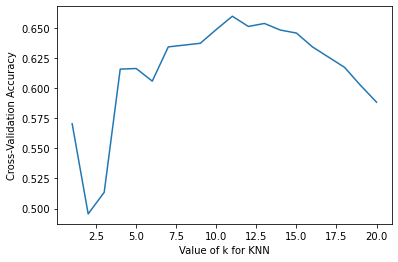

KNeighborsClassifier(n_neighbors=11)

In [10]:
k_values = list(range(1, 21)) 
cross_validation_scores_model = [cross_validate(KNeighborsClassifier(n_neighbors = k), X, Y) for k in k_values] #compute cross validation scores for each alpha for Ridge Regression
mean_validation_scores_model = [data["test_score"].mean() for data in cross_validation_scores_model] #compute mean of cross validation scores
std_validation_scores_model = [data["test_score"].std() for data in cross_validation_scores_model] #compute standard deviation of cross validation scores
best_k = k_values[np.argmax(mean_validation_scores_model)] #determine which alpha gives us best cross validation score

k_scores = []
# use different k in models, then return the average accuracy based on the cross validation
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, Y, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())
# plotting
plt.plot(k_values, k_scores)
plt.xlabel('Value of k for KNN')
plt.ylabel('Cross-Validation Accuracy')
plt.show()

# use best k value for KNN:
model3 = KNeighborsClassifier(n_neighbors = best_k)
model3.fit(X, Y)

The plot above shows the cross validation accuracy with respect to the k values. We can use the plot above to help us determine the optimal k vlaue for KNN classifcation (peak).

# **5. Comparative Analysis**

In order to test our Multinomial naive bayes and K-Nearest Neighbor classifer, we will use our test data. Our test data is also stored in json format, so we will have to parse the json data into pandas dataframe just like how we parsed our training data.

In [11]:
en_df_test = pd.read_json('dataset_en_test.json', lines=True, orient='columns')
es_df_test = pd.read_json('dataset_es_test.json', lines=True, orient='columns')
fr_df_test = pd.read_json('dataset_fr_test.json', lines=True, orient='columns')
de_df_test = pd.read_json('dataset_de_test.json', lines=True, orient='columns')
lang_frames_test = [en_df_test, es_df_test, fr_df_test, de_df_test]
all_reviews_df_test = pd.concat(lang_frames_test)
print('English Reviews: ', len(en_df_test))
print('Spanish Reviews: ', len(es_df_test))
print('French Reviews: ', len(fr_df_test))
print('German Reviews:  ', len(de_df_test))
print('Total Reviews: ',len(all_reviews_df_test))

English Reviews:  5000
Spanish Reviews:  5000
French Reviews:  5000
German Reviews:   5000
Total Reviews:  20000


Next we will clean the test data and use the cleaned data into our models. We will compare the models by comparing the two confusion matrices.

In [12]:
#remove special characters from text column
all_reviews_df_test['review_title'] = all_reviews_df_test['review_title'].str.replace('\W', ' ', regex=True)
# remove numbers and digits form text
all_reviews_df_test['review_title'] = all_reviews_df_test['review_title'].str.replace('\d', ' ', regex=True)
# convert text to lower case
all_reviews_df_test['review_title'] = all_reviews_df_test['review_title'].str.lower()
# remove n spaces and convert to a single space
all_reviews_df_test['review_title'] = all_reviews_df_test['review_title'].str.replace('\s{2,}', ' ', regex=True)
# remove leading and trailing spaces
all_reviews_df_test['review_title'].str.strip()

all_reviews_df_test = all_reviews_df_test[["review_body", "review_title", "language"]]

all_reviews_df_test['language'] = le.transform(all_reviews_df_test['language'])


X = all_reviews_df_test['review_title']
Y = all_reviews_df_test['language']
X = CV.transform(X).toarray()

Y_pred1 = model1.predict(X)
conf_mat1 = confusion_matrix(Y, Y_pred1, labels = model1.classes_)

Y_pred3 = model3.predict(X)
conf_mat3 = confusion_matrix(Y, Y_pred3, labels = model3.classes_)

print(conf_mat1)
print(conf_mat3)

from sklearn.metrics import plot_confusion_matrix



[[4857   58   20   65]
 [ 341 4602   33   24]
 [ 804   26 3988  182]
 [ 720   69   43 4168]]
[[4962    8   26    4]
 [1716 2960  324    0]
 [1539    9 3204  248]
 [1923    8  590 2479]]


To plot our cofusion matrices, we can use ConfusionMatrixDisplay() from sklearn and passing in the confusing_matrix array and labels as parameters.

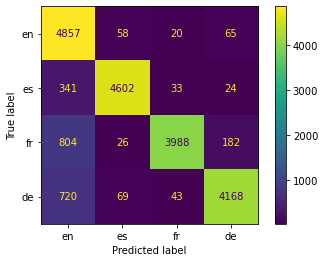

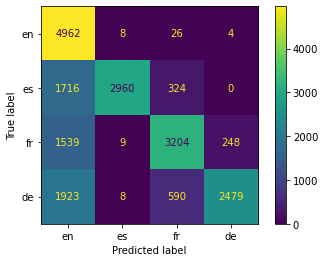

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp1 = ConfusionMatrixDisplay(confusion_matrix=conf_mat1, display_labels= ['en', 'es', 'fr', 'de'])
disp1.plot()
plt.show()
disp2 = ConfusionMatrixDisplay(confusion_matrix=conf_mat3, display_labels= ['en', 'es', 'fr', 'de'])
disp2.plot()
plt.show()

After testing both of our classifer with 5000 reviews for each langauge, we can create confusion matrices for both classifers for comparision. Comparative confusion matrices are also shown above for the bag of words approach. For readability, the matrices are truncated to label encoding: English: 0, Spanish: 1, French: 2, German: 3. We can gather numerous statistics and performance metrics from confusion matrices. Upon first glance of both confusion matrices, we see that Multinomial Naive Bayes perform poorly on trying to clasify Japanese or Chinese. We also see that K-nearest Neighbors is able to classify Chinese text correctly more than Multinomial Naive Bayes model.

With these confusion matrices, we can extract the performance metric, such as precision, recall, accuracy, etc. We see that the True positives for English, Spanish, French, and German is higher for Multinomial Naive Bayes model compared to K Nearest Neighbor Model.

As for deciding which model to put into production, the Multinomial Naive Bayes would be the best to put into production. Comparing the two confusion matrices and performance metrics, it seems that Multinomial Naive Bayes Classifier is better at classifying more langauges than the K Nearest Neighbor model. If possible, the multinomial Naive Bayes model should be used in production for English, Spanish, French, and German language.

Note: If we train / run this notebook again, we may get slightly different results because of the fact that we are sampling 1000 reviews for each langauge.

# **6. Discussion of Ethical Issues**

Language is a complex system of communication that humans use to express themselves. It is through language that one can communicate with others and show his or her ideas. Every country has their own primary language. The primary language for each country is unique to its geographic location, people, and culture. Every language has its unique rules and syntax. In order to communicate or understand a language, one must understand the structure of that language and learn to communicate ideas. On one hand, it would be benefical to develop such a machine learning model that can identify language so that we can break the language barriers. We must keep in mind that such machine learning model can also bring about ethical issues. There are two main ethical issues that come with developing a machine learning model for identify language: (1) Bias, and (2) Privacy.

Although a machine learning model that can detect language of text could be beneficial for companies understanding its customers, it can also bring about negative effects. Since language can be unique to culture or people in specific regions of the world, language can almost always be used to identify one's nationaility or race. Just by connecting language and nationality or race, there could some bias made towards such person. The machine learning model could inadvertently discriminate against marginalized groups. The case that the machine learning model can cause discrimination is not limited to just companies. 


Machine learning models to identify language of text could cause privacy concerns. Companies can use text provided by users and track them based on language of text provided. As mentioned before, since language can partially identify race or nationality of a person, the classifcation of race by language of text can also lead to risk of privacy. For example, there could be ads tracking users based on language of text users provide. The privacy issue is not limited to companies, governments around the world could also use the model. Not all government are democratic, some are ruled by single party. If such government could use a machine learning model to classify race based on language of text by a person (texts, messages, etc), vulnerable individuals and groups of people could suffer disproportionately.

# **7. Bibliography**

https://docs.opendata.aws/amazon-reviews-ml/readme.html#bibliography

Bojanowski, Piotr, et al. “Enriching word vectors with subword information.” Transactions of the Association for Computational Linguistics 5 (2017): 135-146.

Phillip Keung, Yichao Lu, György Szarvas and Noah A. Smith. “The Multilingual Amazon Reviews Corpus.” In Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing, 2020.

@inproceedings{marc_reviews,
    title={The Multilingual Amazon Reviews Corpus},
    author={Keung, Phillip and Lu, Yichao and Szarvas, György and Smith, Noah A.},
    booktitle={Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing},
    year={2020}
}

Zhang, Y., Jin, R. & Zhou, ZH. Understanding bag-of-words model: a statistical framework. Int. J. Mach. Learn. & Cyber. 1, 43–52 (2010). https://doi.org/10.1007/s13042-010-0001-0
